In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/AstroLensing/Libraries') 
%cd '/content/drive/My Drive/AstroLensing'

Mounted at /content/drive
/content/drive/My Drive/AstroLensing


## Prepare the data

In [2]:
import numpy as np
def normalize_image(images):
    #Normalize image to [0,1]
    for i in range(len(images)):
        images[i]=images[i]-images[i].min()
        images[i]=images[i]/images[i].max()
    return images

galaxy_images=np.load('DataSet/Dataset_images_Filtered.npy')
gal_dataset_images=np.reshape(normalize_image(galaxy_images), (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1))
gal_dataset_images=gal_dataset_images[:17280]
x_train=gal_dataset_images[:15520].astype('float32')
x_test=gal_dataset_images[15520:16032].astype('float32')
x_val=gal_dataset_images[16032:17280].astype('float32')

image_size=x_train.shape[1]
batch_size = 32
latent_dim = 64
start_lr = 1e-6

#VAE

## Initialize and compile the model

In [3]:
from VAE import Initialize_VAE,tensor_values
from Representation import plot_galaxies,Show_latent_distr,Learning_curve
models=Initialize_VAE(beta_1=0.5,beta_2=0.999,Loss_type='Beta',Beta=10**-2)
vae=models['vae']
models.keys()

dict_keys(['encoder', 'z_meaner', 'z_log_varer', 'decoder', 'vae'])

## Load weights

In [4]:
Checkpoint_to_load=620
Folder='VAE_Framework/Beta_VAE/'
vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))

## Images for reconstruction quality estimation

In [10]:
#Reconstruction quality is estimated on these images
images_to_reconstruct=np.zeros((32,64,64,1))
images_to_reconstruct=x_test[:batch_size]

indexes_imgs_to_reconstruct=[0,13,28,20,23,27,1,22,30,17]
images_to_reconstruct[:10]=x_test[indexes_imgs_to_reconstruct]

# Training

### Callbacks

In [ ]:
from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard


def on_epoch_end(epoch, logs):
  #Every 10 epoch do the following
    if np.mod(epoch,10)==0:
        clear_output()
        
        #plot 10 original and reconstructed galaxies from test dataset
        decoded = vae.predict(images_to_reconstruct, batch_size=batch_size)
        plot_galaxies(images_to_reconstruct[:10], decoded[:10])

        #Also take a look on how latent space variables are distributed
        Show_latent_distr(models,x_test)

        #Plot last 200 epochs of the learning curve
        Learning_curve(Folder+'logs.txt',np.maximum(Checkpoint_to_load+epoch-200,0),Checkpoint_to_load+epoch)

        if epoch!=0:
          #Make a checkpoint of model weights on Google drive
          Model_folder=Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load+epoch)
          vae.save_weights(Model_folder)

          #Write loss logs
          file_object = open(Folder+'logs.txt', 'a')
          file_object.write(str(logs))
          file_object.write('\n')
          file_object.close()

# Callbacks
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
lr_red = ReduceLROnPlateau(factor=0.1, patience=30, min_lr=1e-8,verbose=1)
tb     = TensorBoard(log_dir='./logs')

### Training

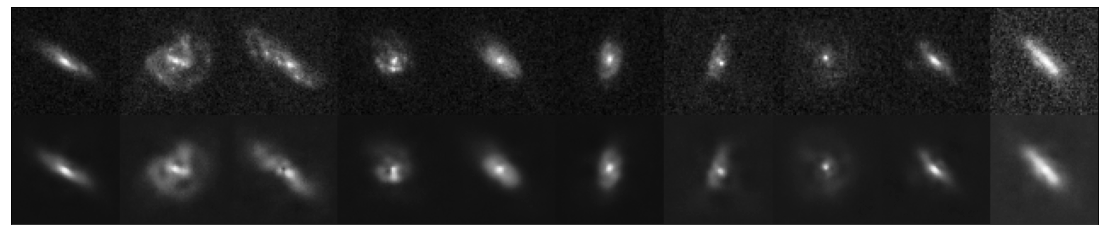

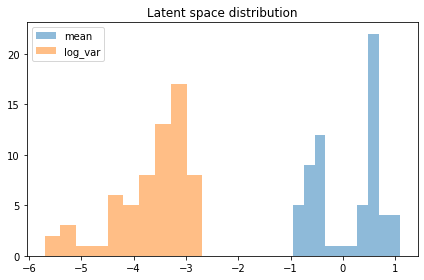

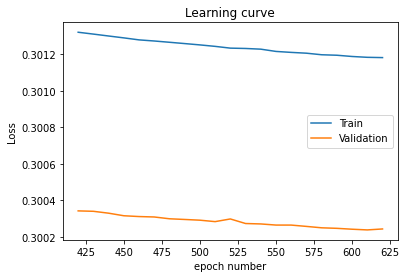

Epoch 2/900
 68/485 [===>..........................] - ETA: 1:22 - loss: 0.3023

KeyboardInterrupt: ignored

In [ ]:
_ = vae.fit(x_train, x_train, shuffle=True, epochs=900,
        batch_size=batch_size,
        validation_data=(x_val, x_val),
        callbacks=[pltfig,lr_red],
        verbose=1)

# Examine results

## Old Functions

In [ ]:
import ast
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import keras.backend as K
import tensorflow as tf


def learning_curve(filename,start_epoch=0,stop_epoch=1000):
  logs_file=open(filename)
  lines=logs_file.readlines()
  logs_file.close()


  loss=np.array([])
  val_loss=np.array([])
  for line in lines:
    note=ast.literal_eval(line)
    loss=np.append(loss,[note['loss']])
    val_loss=np.append(val_loss,[note['val_loss']])

  start_index=start_epoch//10
  stop_index=np.minimum(len(loss),stop_epoch//10)
  plt.plot(10*np.arange(start_index,stop_index),loss[start_index:stop_index],label='loss')
  plt.plot(10*np.arange(start_index,stop_index),val_loss[start_index:stop_index],label='val_loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch number')
  plt.legend()

def latent_distribution(variable='mean'):
  fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
  axs_flat = axs.flatten()  
  for i in range(z_means.shape[1]):
    if variable=='mean':
      axs_flat[i].hist(z_means[:,i], bins=50)
    else:
      axs_flat[i].hist(z_log_vars[:,i], bins=50)
    axs_flat[i].set_title('Z {}'.format(i))
    axs_flat[i].get_yaxis().set_visible(False)
  fig.tight_layout()

def latent_relation_of_variances(sorted=False):
    if sorted:
      g=sns.barplot(x=np.linspace(0,64,64),y=np.sort(ratio)[::-1])
    else:
      g=sns.barplot(x=np.linspace(0,64,64),y=ratio)
    #g.xaxis.set_visible(False)
    plt.hlines(1,0,63,label=r'$\mu_{std}=\sigma_{mean}$')
    plt.legend()
    plt.xticks([])
    plt.xlabel('Latent variable')
    plt.ylabel('Ratio')
    plt.title(r'$\mu_{std}/\sigma_{mean}$')

def galaxy_properties_from_latent_variables(number_of_z_to_consider=64):
  latent_average=z_means.mean(axis=0)
  variables_to_consider=np.argsort(ratio)[::-1][:number_of_z_to_consider]
  variances_to_consider=np.exp(z_log_vars.std(axis=0)[variables_to_consider]/2)
  z_to_consider=np.zeros((number_of_z_to_consider,7,64))
  #i - number of variable to change
  for i in range(number_of_z_to_consider):
    #j - number of sigmas to add to it
    for j in range(7):
      #Assign everything to be like average galaxy
      z_to_consider[i,j,:]=latent_average
      #Vary one of the variables to get mu+-(0,1,2,3)*sigma
      z_to_consider[i,j,variables_to_consider[i]]+=(j-3)*variances_to_consider[i]
  images_to_consider=models['decoder'].predict(z_to_consider.reshape((number_of_z_to_consider*7,64)))
  #plot_digits(images_to_consider[:7],images_to_consider[7:14])
  for i in range(number_of_z_to_consider):
    plot_digits(images_to_consider[i*7:(i+1)*7],show=False)

def rotational_invariance_and_denoising():
  imgs_turned=copy.deepcopy(imgs)
  imgs_turned[0]=imgs[0,::-1,:,:]
  imgs_turned[1]=imgs[0]
  imgs_turned[2:5]=[imgs[0]+np.random.normal(0,1/i,imgs[0].shape) for i in range(60,10,-20)]
  decoded_turned= vae.predict(imgs_turned, batch_size=batch_size)
  plot_digits(imgs_turned[:5],decoded_turned[:5],show=False)

def loss_functions_distribution(KL_type='Original'):
  loss_func=tf.keras.losses.binary_crossentropy

  #reconstruction quality
  flattened_x=K.reshape(gal_dataset_images,shape=(len(gal_dataset_images),image_size*image_size))
  flattened_decoded=K.reshape(decoded,shape=(len(gal_dataset_images),image_size*image_size))
  Log_loss=image_size*image_size*loss_func(flattened_x,flattened_decoded)

  KL_loss=0.5 * K.sum(1 + z_log_vars - K.square(z_means) - K.exp(z_log_vars), axis=-1)

  #Choice of loss function
  Beta_Loss=(Log_loss-beta_vae*KL_loss)/image_size/image_size
  
  free_bits_tensor=K.constant(free_bits*np.ones(KL_loss.shape[0]))
  Flow_Loss=(Log_loss-K.maximum(-free_bits_tensor,KL_loss))/image_size/image_size

  if KL_type=='Original':
    KL_to_show=KL_loss/image_size/image_size
  elif KL_type=='Beta':
    KL_to_show=beta_vae*KL_loss/image_size/image_size
  elif KL_type=='Flow':
    KL_to_show=(KL_loss)/image_size/image_size
    print('Flow_KL=max({:.5f},KL_loss)'.format(-free_bits/image_size/image_size))
  else:
    print('wrong type')
    return


  fig,ax=plt.subplots(1,2)

  ax[0].hist(Log_loss/image_size/image_size,bins=100)
  ax[0].set_title('Binary crossentropy')
  
  ax[1].hist(KL_to_show,bins=100)
  ax[1].set_title(KL_type+' KL divergence')

  plt.tight_layout()

def show_train_stats(models,logs_filename,images,start_epoch=0,stop_epoch=1000,Latent_SNR_sorted=True,Loss_type='Original',Beta=10**-2,free_bits=40,image_size=64,batch_size=32):
  fig,ax=plt.subplots(1,4,figsize=(30,5))

  #Plot learning curve
  logs_file=open(logs_filename)
  lines=logs_file.readlines()
  logs_file.close()

  loss=np.array([])
  val_loss=np.array([])
  for line in lines:
    note=ast.literal_eval(line)
    loss=np.append(loss,[note['loss']])
    val_loss=np.append(val_loss,[note['val_loss']])

  start_index=start_epoch//10
  stop_index=np.minimum(len(loss),stop_epoch//10+1)
  ax[0].plot(10*np.arange(start_index,stop_index),loss[start_index:stop_index],label='Train')
  ax[0].plot(10*np.arange(start_index,stop_index),val_loss[start_index:stop_index],label='Validation')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('epoch number')
  ax[0].set_title('Learning curve')
  ax[0].legend()

  #Plot latent space SNR
  z_means = models['z_meaner'].predict(images)
  z_log_vars=models['z_log_varer'].predict(images)
  std_of_mu=z_means.std(axis=0)
  mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
  Latent_SNR=std_of_mu/mean_of_var

  if Latent_SNR_sorted:
    g=sns.barplot(ax=ax[1],x=np.linspace(0,64,64),y=np.sort(Latent_SNR)[::-1])
  else:
    g=sns.barplot(ax=ax[1],x=np.linspace(0,64,64),y=Latent_SNR)
  ax[1].hlines(1,0,63,label=r'$\mu_{std}=\sigma_{mean}$')
  ax[1].legend()
  ax[1].set_xticks([])
  ax[1].set_xlabel('Latent variable')
  ax[1].set_ylabel('Ratio')
  ax[1].set_title(r'Latent SNR = $\mu_{std}/\sigma_{mean}$')

  #Plot Binary_CE and KL_divergence histograms

  #Reconstruction quality
  flattened_x=K.reshape(images,shape=(len(images),image_size*image_size))
  flattened_decoded=K.reshape(decoded,shape=(len(images),image_size*image_size))
  Log_loss=image_size*image_size*tf.keras.losses.binary_crossentropy(flattened_x,flattened_decoded)

  #Latent space regularization
  KL_loss=0.5 * K.sum(1 + z_log_vars - K.square(z_means) - K.exp(z_log_vars), axis=-1)

  ax[2].hist(Log_loss/image_size/image_size,bins=100)
  ax[2].set_title('Binary crossentropy')
  ax[2].set_xlabel('Loss per image pixel')
  
  ax[3].hist(KL_loss/image_size/image_size,bins=100)
  ax[3].set_title('KL divergence')
  ax[3].set_xlabel('Loss per image pixel')
  if Loss_type=='Beta':
    print('Loss uses {:.2f}xKL_diverngence'.format(Beta))
  elif Loss_type=='Flow':
    print('Loss uses max(-{:.2f},KL_diverngence'.format(free_bits))
  
  plt.show()


def present_reconstruction(resid=False):
    imgs=x_test[:batch_size]
    images_for_reconst=np.zeros((32,64,64,1))

    #Images selection
    images_for_reconst[0]=imgs[0]
    images_for_reconst[1]=imgs[13]
    images_for_reconst[2]=imgs[28]
    images_for_reconst[3]=imgs[20]
    images_for_reconst[4]=imgs[23]
    images_for_reconst[5]=imgs[27]
    images_for_reconst[6]=imgs[1]
    images_for_reconst[7]=imgs[22]
    images_for_reconst[8]=imgs[30]
    images_for_reconst[9]=imgs[17]

    decoded_to_reconstruct=vae.predict(images_for_reconst, batch_size=batch_size)
    if resid:
      residuals=decoded_to_reconstruct-images_for_reconst
      plot_galaxies(images_for_reconst[:10],decoded_to_reconstruct[:10],residuals[:10])
      plt.colorbar()
    else:
      plot_galaxies(images_for_reconst[:10],decoded_to_reconstruct[:10])

In [ ]:
def get_statistics(models,images):
  z_means = models['z_meaner'].predict(images)
  z_log_vars=models['z_log_varer'].predict(images)
  std_of_mu=z_means.std(axis=0)
  mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
  Latent_SNR=std_of_mu/mean_of_var
  return z_means,z_log_vars,Latent_SNR

def show_train_stats(models,statistics,logs_filename,images,start_epoch=0,stop_epoch=1000,Latent_SNR_sorted=True,Loss_type='Original',Beta=10**-2,free_bits=40,image_size=64,batch_size=32):
  z_means,z_log_vars,Latent_SNR=statistics
  fig,ax=plt.subplots(1,4,figsize=(30,5))

  #Plot learning curve
  logs_file=open(logs_filename)
  lines=logs_file.readlines()
  logs_file.close()

  loss=np.array([])
  val_loss=np.array([])
  for line in lines:
    note=ast.literal_eval(line)
    loss=np.append(loss,[note['loss']])
    val_loss=np.append(val_loss,[note['val_loss']])

  start_index=start_epoch//10
  stop_index=np.minimum(len(loss),stop_epoch//10+1)
  ax[0].plot(10*np.arange(start_index,stop_index),loss[start_index:stop_index],label='Train')
  ax[0].plot(10*np.arange(start_index,stop_index),val_loss[start_index:stop_index],label='Validation')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('epoch number')
  ax[0].set_title('Learning curve')
  ax[0].legend()

  if Latent_SNR_sorted:
    g=sns.barplot(ax=ax[1],x=np.linspace(0,64,64),y=np.sort(Latent_SNR)[::-1])
  else:
    g=sns.barplot(ax=ax[1],x=np.linspace(0,64,64),y=Latent_SNR)
  ax[1].hlines(1,0,63,label=r'$\mu_{std}=\sigma_{mean}$')
  ax[1].legend()
  ax[1].set_xticks([])
  ax[1].set_xlabel('Latent variable')
  ax[1].set_ylabel('Ratio')
  ax[1].set_title(r'Latent SNR = $\mu_{std}/\sigma_{mean}$')

  #Plot Binary_CE and KL_divergence histograms

  #Reconstruction quality
  flattened_x=K.reshape(images,shape=(len(images),image_size*image_size))
  flattened_decoded=K.reshape(models['vae'].predict(images),shape=(len(images),image_size*image_size))
  Log_loss=image_size*image_size*tf.keras.losses.binary_crossentropy(flattened_x,flattened_decoded)

  #Latent space regularization
  KL_loss=0.5 * K.sum(1 + z_log_vars - K.square(z_means) - K.exp(z_log_vars), axis=-1)

  ax[2].hist(Log_loss/image_size/image_size,bins=100)
  ax[2].set_title('Binary crossentropy')
  ax[2].set_xlabel('Loss per image pixel')

  ax[3].hist(KL_loss/image_size/image_size,bins=100)
  ax[3].set_title('KL divergence')
  ax[3].set_xlabel('Loss per image pixel')
  if Loss_type=='Beta':
    print('Loss uses {:.2f}xKL_diverngence'.format(Beta))
  elif Loss_type=='Flow':
    print('Loss uses max(-{:.2f},KL_diverngence'.format(free_bits))

  plt.show()

def rotational_invariance_and_denoising(models,imgs):
  imgs_turned=copy.deepcopy(imgs)
  imgs_turned[0]=imgs[0,::-1,:,:]
  imgs_turned[1]=imgs[0]
  imgs_turned[2:5]=[imgs[0]+np.random.normal(0,1/i,imgs[0].shape) for i in range(60,10,-20)]
  decoded_turned= models['vae'].predict(imgs_turned, batch_size=batch_size)
  plot_galaxies(imgs_turned[:5],decoded_turned[:5])


def galaxy_properties_from_latent_variables(models,statistics,number_of_z_to_consider=64):
  z_means,z_log_vars,Latent_SNR=statistics
  
  latent_average=z_means.mean(axis=0)
  variables_to_consider=np.argsort(Latent_SNR)[::-1][:number_of_z_to_consider]
  variances_to_consider=np.exp(z_log_vars.std(axis=0)[variables_to_consider]/2)
  z_to_consider=np.zeros((number_of_z_to_consider,7,64))
  #i - number of variable to change
  for i in range(number_of_z_to_consider):
    #j - number of sigmas to add to it
    for j in range(7):
      #Assign everything to be like average galaxy
      z_to_consider[i,j,:]=latent_average
      #Vary one of the variables to get mu+-(0,1,2,3)*sigma
      z_to_consider[i,j,variables_to_consider[i]]+=(j-3)*variances_to_consider[i]
  images_to_consider=models['decoder'].predict(z_to_consider.reshape((number_of_z_to_consider*7,64)))
  for i in range(number_of_z_to_consider):
    plot_galaxies(images_to_consider[i*7:(i+1)*7])

## New Func

In [13]:
from Representation import present_reconstruction,get_Latent_Space,show_train_stats,rotational_invariance_and_denoising,galaxy_properties_from_latent_variables,latent_distribution

## Examination

### Original VAE

In [6]:
models=Initialize_VAE(beta_1=0.5,beta_2=0.999,Loss_type='Original')
vae=models['vae']

Checkpoint_to_load=640
Folder='VAE_Framework/Research_Original_VAE/'
vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))
Latent_Space=get_Latent_Space(models,gal_dataset_images)

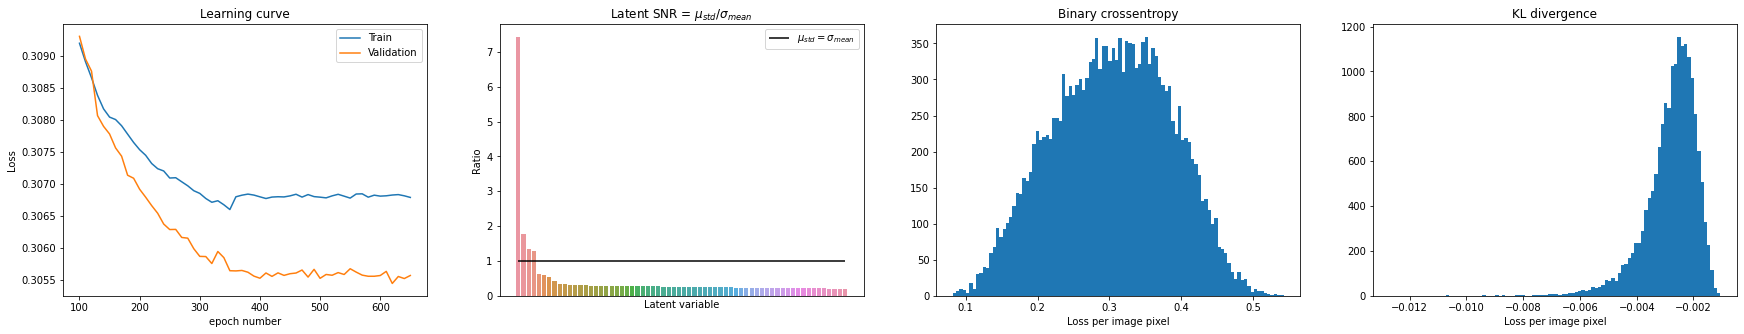

In [9]:
show_train_stats(models,Latent_Space,Folder+'logs.txt',gal_dataset_images,start_epoch=100,stop_epoch=700,Latent_SNR_sorted=True,Loss_type='Original')

In [11]:
present_reconstruction(models,images_to_reconstruct)

NameError: ignored

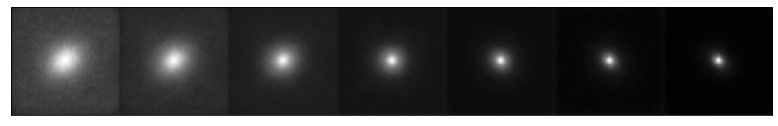

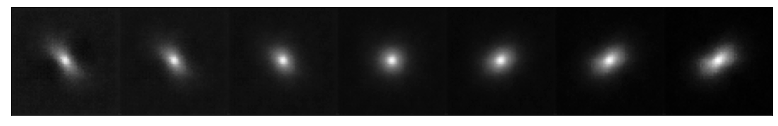

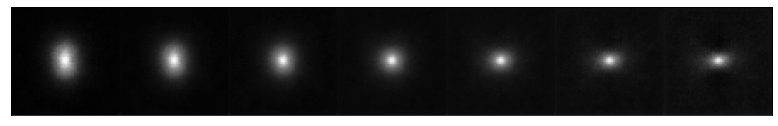

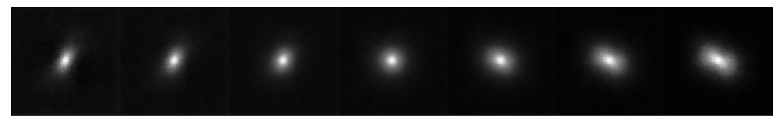

In [16]:
galaxy_properties_from_latent_variables(models,Latent_Space,4)

In [15]:
#latent_distribution(Latent_Space,variable='mean')

### Beta VAE

In [17]:
models=Initialize_VAE(beta_1=0.5,beta_2=0.999,Loss_type='Beta',Beta=10**-2)
vae=models['vae']

Checkpoint_to_load=620
Folder='VAE_Framework/Beta_VAE/'
vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))
Latent_Space=get_Latent_Space(models,gal_dataset_images)

Loss uses 0.01xKL_diverngence


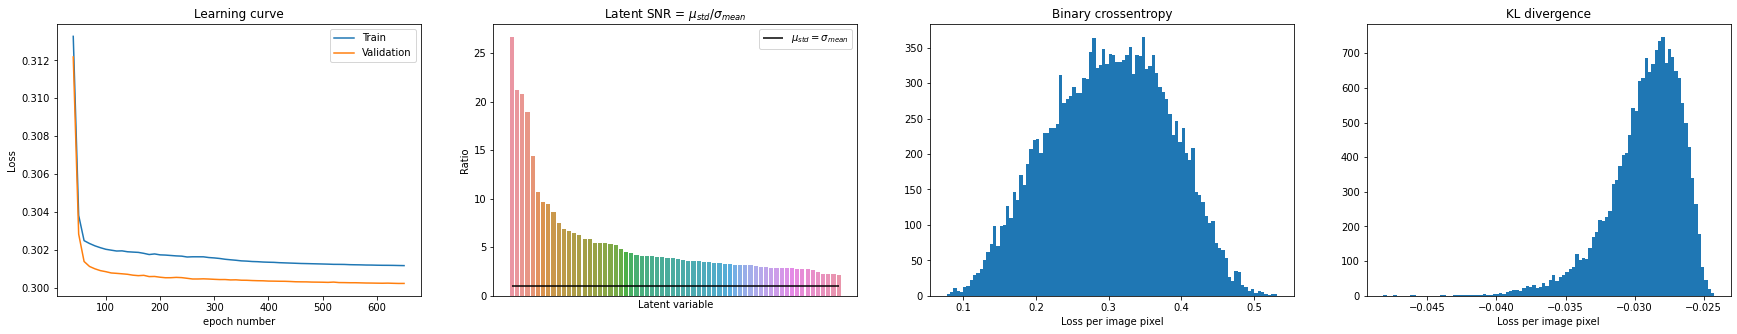

In [18]:
show_train_stats(models,Latent_Space,Folder+'logs.txt',gal_dataset_images,start_epoch=40,stop_epoch=700,Latent_SNR_sorted=True,Loss_type='Beta',Beta=10**-2)

In [19]:
present_reconstruction(models,images_to_reconstruct)

AttributeError: ignored

In [ ]:
present_reconstruction(models,images_to_reconstruct,resid=True)

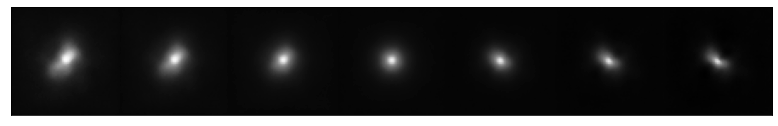

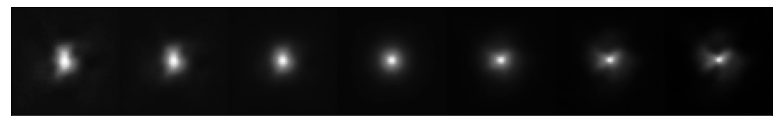

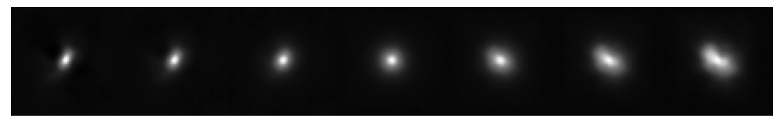

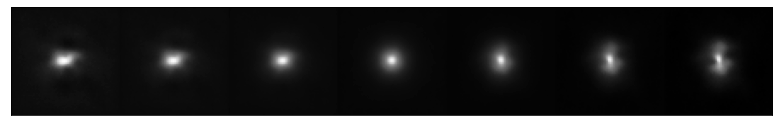

In [20]:
galaxy_properties_from_latent_variables(models,Latent_Space,4)

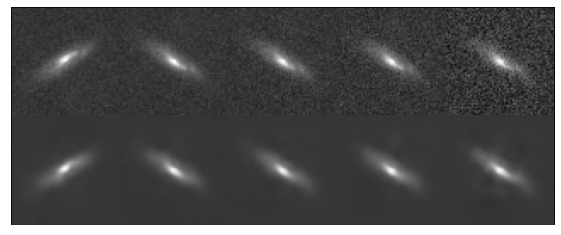

In [21]:
rotational_invariance_and_denoising(models,x_test[:batch_size])

In [ ]:
#latent_distribution(Latent_Space,variable='mean')

### Flow VAE

#### free_bits=4

In [28]:
free_bits=4
models=Initialize_VAE(beta_1=0.5,beta_2=0.999,Loss_type='Flow',free_bits=free_bits)
vae=models['vae']

Checkpoint_to_load=180
Folder='VAE_Framework/Research_Flow_VAE/min4/'
vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))
Latent_Space=get_Latent_Space(models,gal_dataset_images)

Loss uses max(-4.00,KL_diverngence


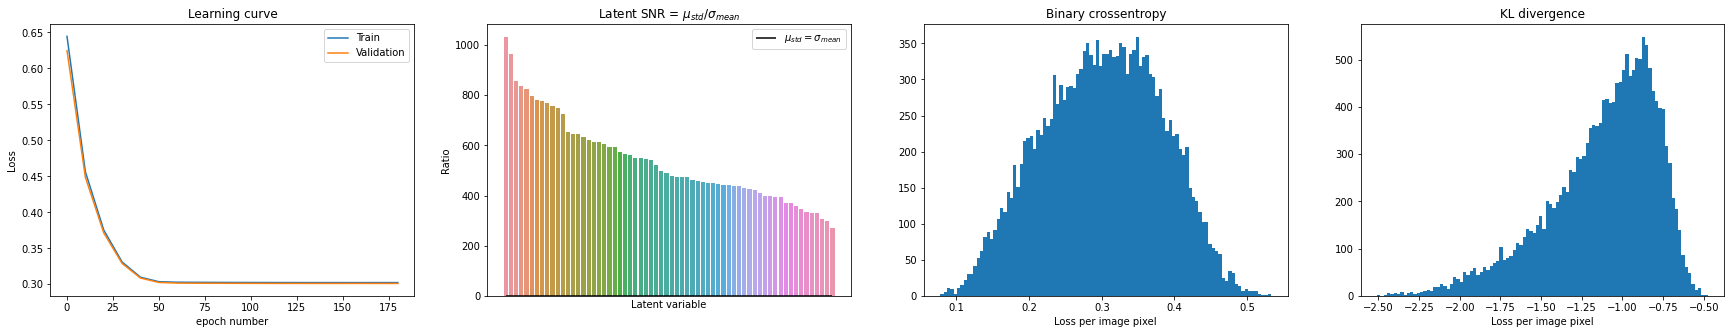

In [29]:
show_train_stats(models,Latent_Space,Folder+'logs.txt',gal_dataset_images,Latent_SNR_sorted=True,Loss_type='Flow',free_bits=free_bits)

Conclusion - to weak flow, the constraint must be increased

#### free_bits=8

In [31]:
free_bits=8
models=Initialize_VAE(beta_1=0.5,beta_2=0.999,Loss_type='Flow',free_bits=free_bits)
vae=models['vae']

Checkpoint_to_load=120
Folder='VAE_Framework/Research_Flow_VAE/min8/'
vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))
Latent_Space=get_Latent_Space(models,gal_dataset_images)

Loss uses max(-8.00,KL_diverngence


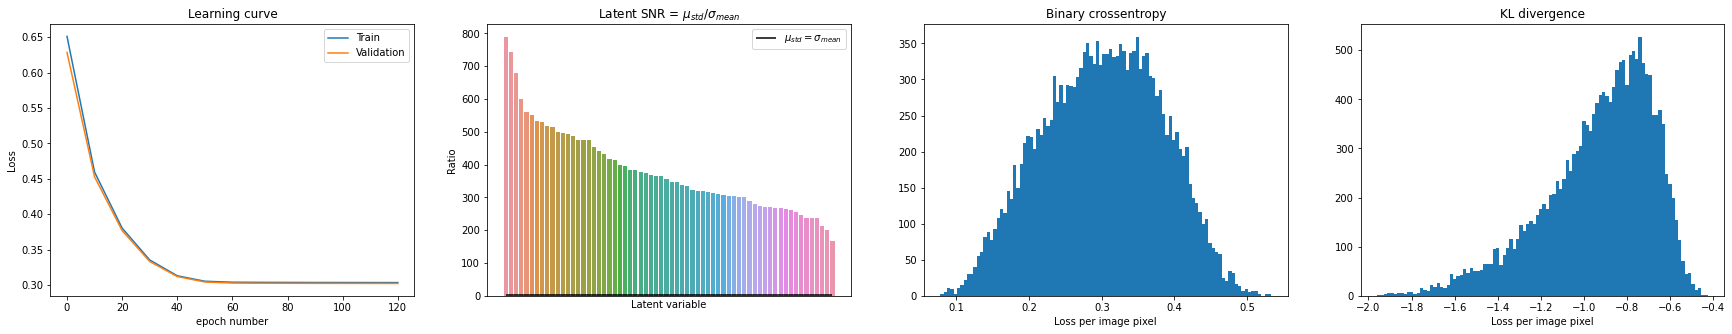

In [32]:
show_train_stats(models,Latent_Space,Folder+'logs.txt',gal_dataset_images,Latent_SNR_sorted=True,Loss_type='Flow',free_bits=free_bits)

#### free_bits=16

In [33]:
free_bits=16
models=Initialize_VAE(beta_1=0.5,beta_2=0.999,Loss_type='Flow',free_bits=free_bits)
vae=models['vae']

Checkpoint_to_load=120
Folder='VAE_Framework/Research_Flow_VAE/min16/'
vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))
Latent_Space=get_Latent_Space(models,gal_dataset_images)

Loss uses max(-16.00,KL_diverngence


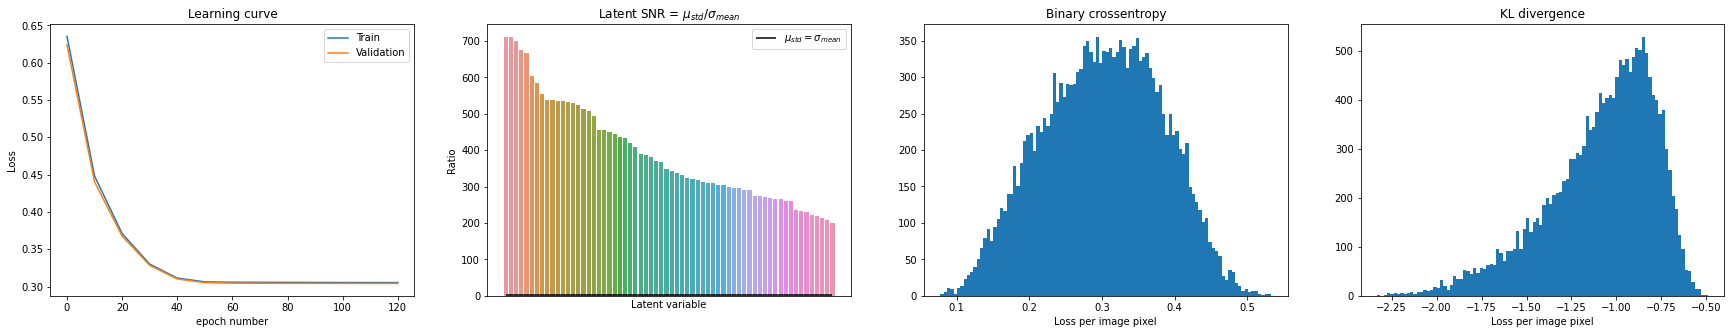

In [34]:
show_train_stats(models,Latent_Space,Folder+'logs.txt',gal_dataset_images,Latent_SNR_sorted=True,Loss_type='Flow',free_bits=free_bits)

#### free_bits=32

In [35]:
free_bits=32
models=Initialize_VAE(beta_1=0.5,beta_2=0.999,Loss_type='Flow',free_bits=free_bits)
vae=models['vae']

Checkpoint_to_load=120
Folder='VAE_Framework/Research_Flow_VAE/min32/'
vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))
Latent_Space=get_Latent_Space(models,gal_dataset_images)

Loss uses max(-32.00,KL_diverngence


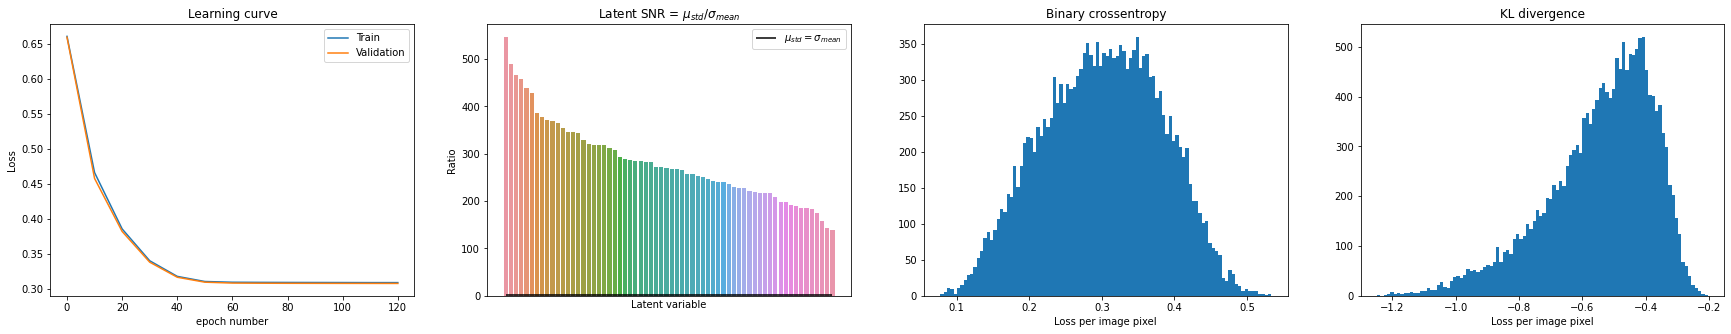

In [36]:
show_train_stats(models,Latent_Space,Folder+'logs.txt',gal_dataset_images,Latent_SNR_sorted=True,Loss_type='Flow',free_bits=free_bits)

#### free_bits=64

In [38]:
free_bits=64
models=Initialize_VAE(beta_1=0.5,beta_2=0.999,Loss_type='Flow',free_bits=free_bits)
vae=models['vae']

Checkpoint_to_load=120
Folder='VAE_Framework/Research_Flow_VAE/min64/'
vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))
Latent_Space=get_Latent_Space(models,gal_dataset_images)

Loss uses max(-64.00,KL_diverngence


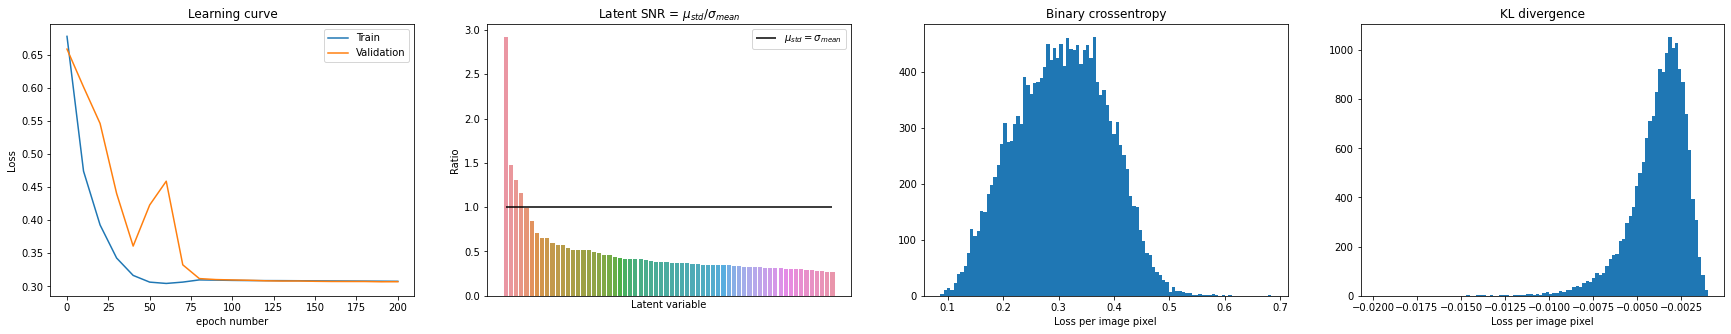

In [39]:
show_train_stats(models,Latent_Space,Folder+'logs.txt',gal_dataset_images,Latent_SNR_sorted=True,Loss_type='Flow',free_bits=free_bits)

#### free_bits=40

In [40]:
free_bits=40
models=Initialize_VAE(beta_1=0.5,beta_2=0.999,Loss_type='Flow',free_bits=free_bits)
vae=models['vae']

Checkpoint_to_load=80
Folder='VAE_Framework/Research_Flow_VAE/min40/'
vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))
Latent_Space=get_Latent_Space(models,gal_dataset_images)

Loss uses max(-40.00,KL_diverngence


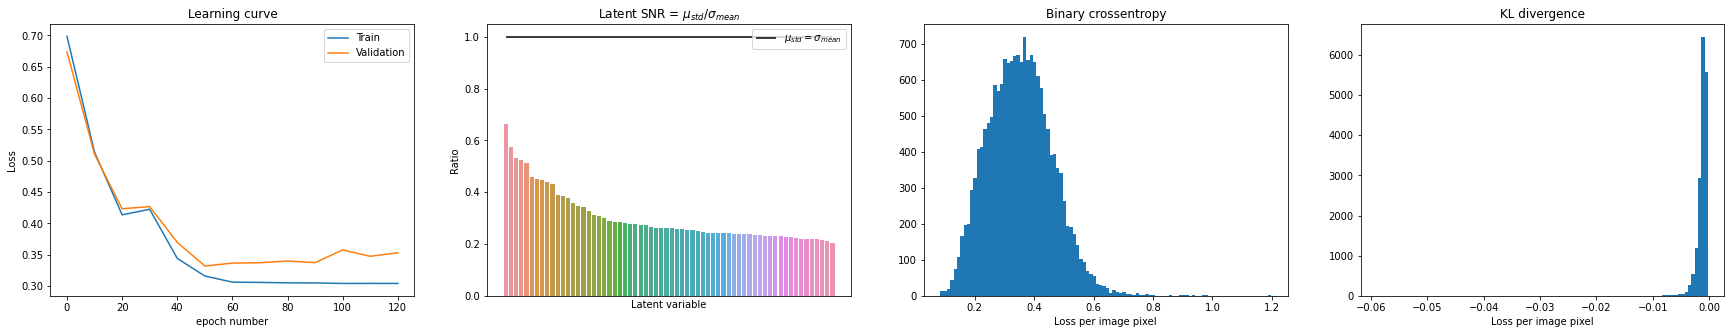

In [41]:
show_train_stats(models,Latent_Space,Folder+'logs.txt',gal_dataset_images,Latent_SNR_sorted=True,Loss_type='Flow',free_bits=free_bits)

#### free_bits=48

In [43]:
free_bits=48
models=Initialize_VAE(beta_1=0.5,beta_2=0.999,Loss_type='Flow',free_bits=free_bits)
vae=models['vae']

Checkpoint_to_load=60
Folder='VAE_Framework/Research_Flow_VAE/min48/'
vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))
Latent_Space=get_Latent_Space(models,gal_dataset_images)

Loss uses max(-48.00,KL_diverngence


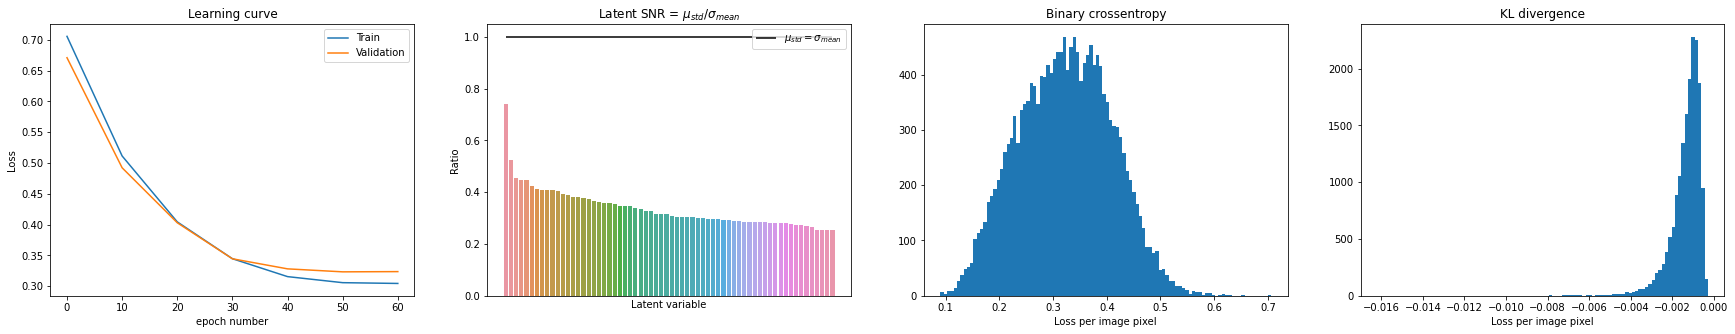

In [44]:
show_train_stats(models,Latent_Space,Folder+'logs.txt',gal_dataset_images,Latent_SNR_sorted=True,Loss_type='Flow',free_bits=free_bits)

#### free_bits=56

In [45]:
free_bits=56
models=Initialize_VAE(beta_1=0.5,beta_2=0.999,Loss_type='Flow',free_bits=free_bits)
vae=models['vae']

Checkpoint_to_load=120
Folder='VAE_Framework/Research_Flow_VAE/min56/'
vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoint_to_load))
Latent_Space=get_Latent_Space(models,gal_dataset_images)

Loss uses max(-56.00,KL_diverngence


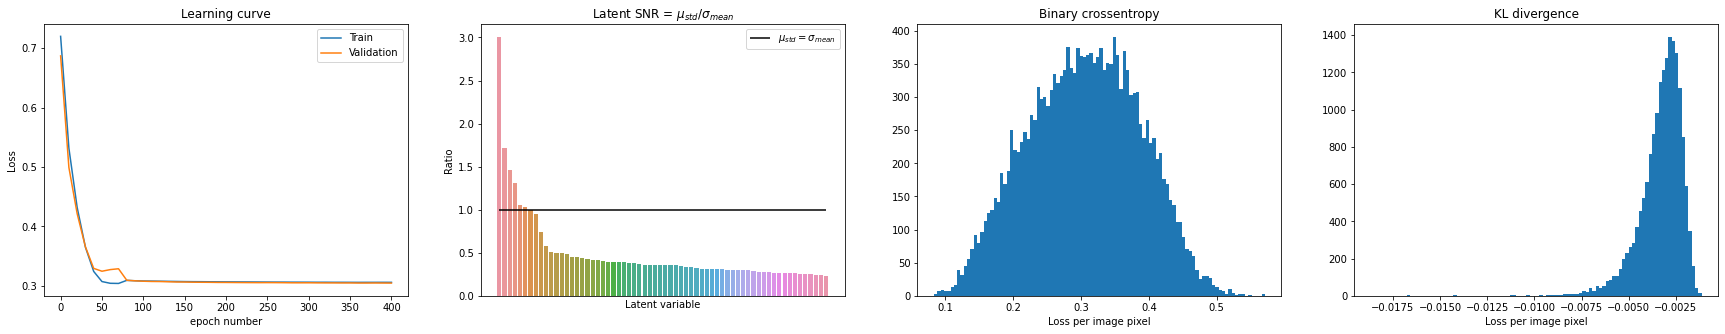

In [46]:
show_train_stats(models,Latent_Space,Folder+'logs.txt',gal_dataset_images,Latent_SNR_sorted=True,Loss_type='Flow',free_bits=free_bits)

#### overall study of flow

In [52]:
from tqdm import tqdm
SNRs=np.zeros((8,3))
lambdas=[4,8,16,32,40,48,56,64]
Checkpoints=[180,120,120,120,80,60,120,120]
reconstructed_image=np.zeros((9,64,64,1))
imgs=x_test[:batch_size]
reconstructed_image[0]=imgs[13]
for i,bits in tqdm(enumerate(lambdas)):
  Folder='VAE_Framework/Research_Flow_VAE/min{}/'.format(bits)
  vae.load_weights(Folder+'Checkpoints/epoch_{}/Model'.format(Checkpoints[i]))
  reconstructed_image[i+1]=vae.predict(imgs)[13]
  z_means=models['z_meaner'].predict(gal_dataset_images)
  z_log_vars=models['z_log_varer'].predict(gal_dataset_images)
  std_of_mu=z_means.std(axis=0)
  mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
  ratio=std_of_mu/mean_of_var
  SNRs[i]=[ratio.max(),ratio.mean(),ratio.min()]

8it [02:38, 19.87s/it]


In [53]:
Folder='VAE_Framework/Research_Flow_VAE/'

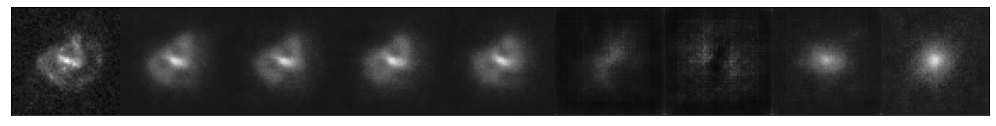

In [55]:
reconstructed_image[-1]=vae.predict(imgs)[13]
plot_galaxies(reconstructed_image)
#plt.savefig(Folder+'reconstruction')

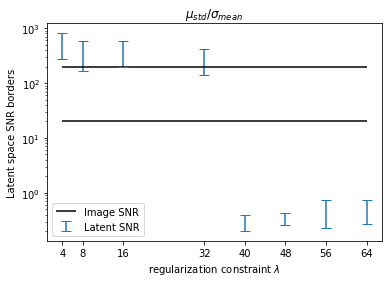

In [57]:
import matplotlib.pyplot as plt

plt.errorbar(lambdas,SNRs[:,1],[SNRs[:,1]-SNRs[:,2],SNRs[:,1]-SNRs[:,2]],fmt='none',capsize=5,label='Latent SNR')
plt.xticks(lambdas)
plt.hlines(20,4,64,label='Image SNR')
plt.hlines(200,4,64)
plt.legend(loc='lower left')
plt.title(r'$\mu_{std}/\sigma_{mean}$')
plt.xlabel(r'regularization constraint $\lambda$')
plt.ylabel('Latent space SNR borders')
plt.yscale('log')
#plt.savefig(Folder+'SNR_on_lambda')